In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeDefaultTransforms

/anaconda/envs/py37_pytorch_003/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda/envs/py37_pytorch_003/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# Script runtime options
root_dir = '..' # '/home/jupyter/caltech_birds'
model = 'resnext101_64x4d'
data_root_dir = os.path.join(root_dir, 'data')
model_root_dir = os.path.join(root_dir, 'models')
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [3]:
# Get data transforms
data_transforms = makeDefaultTransforms()

In [4]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

In [5]:
# Setup the device to run the computations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device::', device)

Device:: cuda:0


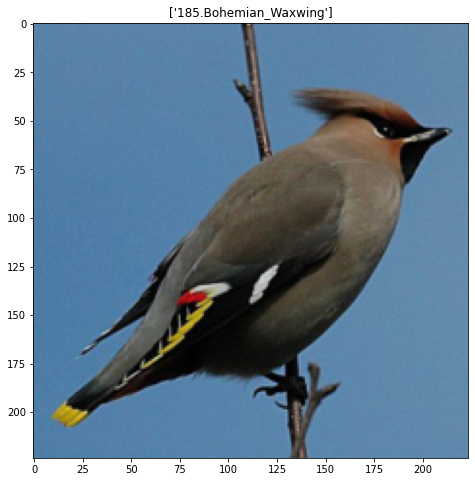

In [6]:
# Check the augmentations
# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
# Load the extracted feature maps
feature_maps_dict = unpickle(os.path.join(output_dir,'{}_feature_extractions.pkl'.format(model)))
features = np.array(feature_maps_dict['feature extractions']).squeeze()

In [8]:
features.shape

(5794, 2048)

In [9]:
feature_maps_dict.keys()

dict_keys(['labels truth', 'labels pred', 'image paths', 'feature extractions'])

# Domain Reduction - Principal Components Analysis

## Assess all components

Compute all components to assess the number of components required to reconstruct 95% of the feature map information.

In [10]:
# Domain reduction
from sklearn.decomposition import PCA

/anaconda/envs/py37_pytorch_003/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda/envs/py37_pytorch_003/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda/envs/py37_pytorch_003/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [11]:
pca = PCA()
pca.fit(features)

PCA()

In [12]:
cum_explained_variance_ratio= []
cumsum=0.
for comp in pca.explained_variance_ratio_:
    cumsum += comp
    cum_explained_variance_ratio.append( cumsum )

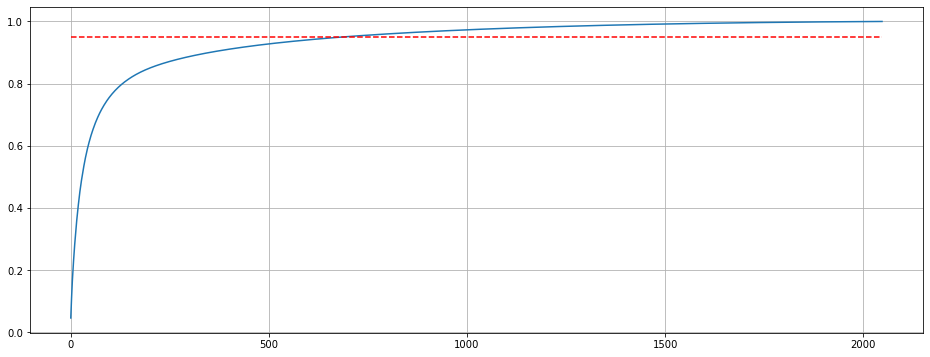

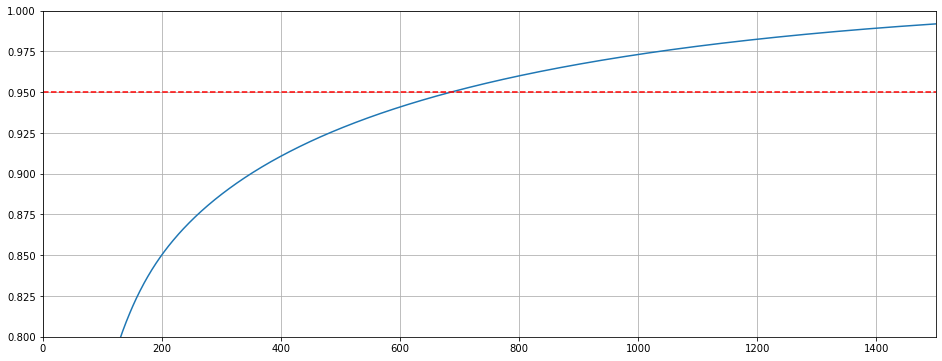

In [13]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(0,len(cum_explained_variance_ratio),1),cum_explained_variance_ratio)
plt.plot([0, len(cum_explained_variance_ratio)], [0.95, 0.95], 'r--')
plt.grid(True)
plt.yscale('linear')
plt.show()

plt.figure(figsize=(16,6))
plt.plot(np.arange(0,len(cum_explained_variance_ratio),1),cum_explained_variance_ratio)
plt.plot([0, len(cum_explained_variance_ratio)], [0.95, 0.95], 'r--')
plt.grid(True)
plt.yscale('linear')
plt.ylim([0.8,1.0])
plt.xlim([0, 1500])
plt.show()

## Compute the PCA transform and apply to the feature maps

1000 components was found to recover ~95% of the variance in the data.
This is domain reduction from 4096 to 1000 dimensions.

In [14]:
pca = PCA(n_components=700)
pca.fit(features)

PCA(n_components=700)

In [15]:
pca_features = pca.transform(features)

In [16]:
pca_features.shape

(5794, 700)

In [17]:
pca_features_dict = {'pca_features' : pca_features,
                     'pca_model' : pca,
                     'n_components' : 1000,
                     'cumulative explained variance ratio (all components)' : cum_explained_variance_ratio}

In [18]:
save_pickle(pca_features_dict, os.path.join(output_dir,'{}_pca_feature_extractions.pkl'.format(model)))

# Manifold Learning Representations


In [19]:
def get_manifold_df(trf_data, labels, class_names):
    labels_name = []
    for label in labels:
        labels_name.append( class_names[label] )
    return pd.DataFrame({'Manifold Dim 1' : trf_data[:,0], 
                         'Manifold Dim 2' : trf_data[:,1], 
                         'label (truth)' : labels, 
                         'class name (truth)' : labels_name})

## t-SNE of image feature maps

In [20]:
from sklearn.manifold import TSNE

/anaconda/envs/py37_pytorch_003/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [21]:
tsne = TSNE(n_components=2, learning_rate=150, perplexity=50, angle=0.2, verbose=2).fit_transform(pca_features)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5794 samples in 0.297s...
[t-SNE] Computed neighbors for 5794 samples in 35.580s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5794
[t-SNE] Computed conditional probabilities for sample 2000 / 5794
[t-SNE] Computed conditional probabilities for sample 3000 / 5794
[t-SNE] Computed conditional probabilities for sample 4000 / 5794
[t-SNE] Computed conditional probabilities for sample 5000 / 5794
[t-SNE] Computed conditional probabilities for sample 5794 / 5794
[t-SNE] Mean sigma: 8.772870
[t-SNE] Computed conditional probabilities in 0.608s
[t-SNE] Iteration 50: error = 85.8000717, gradient norm = 0.0064579 (50 iterations in 2.130s)
[t-SNE] Iteration 100: error = 75.0219498, gradient norm = 0.0038168 (50 iterations in 1.528s)
[t-SNE] Iteration 150: error = 73.7478333, gradient norm = 0.0011300 (50 iterations in 1.276s)
[t-SNE] Iteration 200: error = 73.5220871, gradient norm = 0.0004753 (50 iterations in 1.367s)


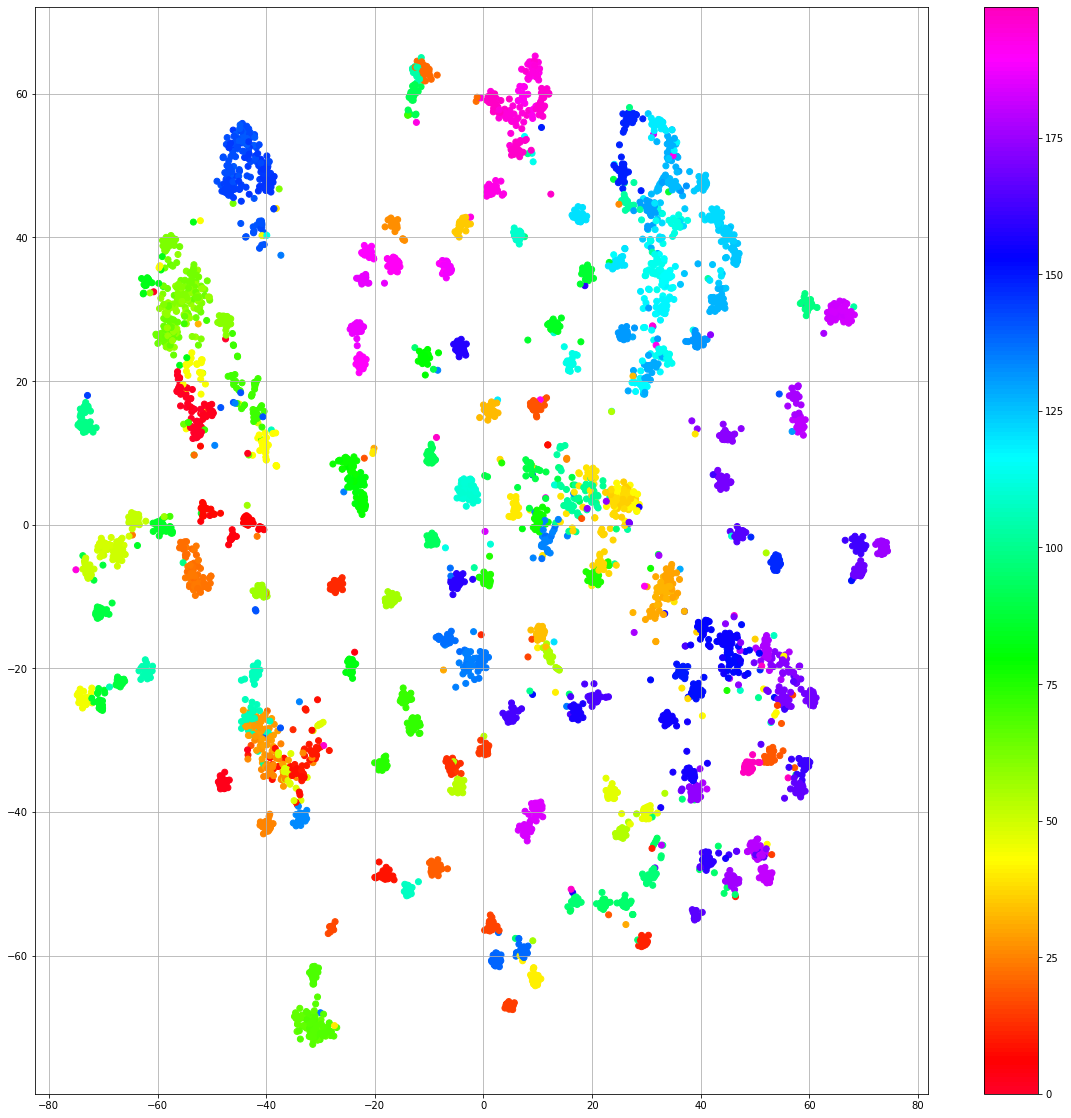

In [22]:
plt.figure(figsize=(20,20))
plt.scatter(tsne[:,0], tsne[:,1], c=feature_maps_dict['labels truth'], cmap='gist_rainbow')
plt.colorbar()
plt.grid(True)
plt.show()

In [23]:
tsne_df = get_manifold_df(trf_data=tsne, labels=feature_maps_dict['labels truth'], class_names=class_names)

In [26]:
!conda install hvplot -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.1
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /anaconda/envs/py37_pytorch_003

  added / updated specs:
    - hvplot


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.1 MB

The following NEW packages will be INSTALLED:

  attrs              conda-forge/noarch::attrs-19.3.0-py_0
  bleach             conda-forge/noarch::bleach-3.1.5-pyh9f0ad1d_0
  bokeh              conda-forge/linux-64::bokeh-2.1.1-py37hc8dfbb8_0
  brotlipy           conda-forge/linux-64::brotlipy-0.7.0-py37h8f50634_1000
  c

In [27]:
import hvplot.pandas

In [28]:
tsne_df.hvplot.scatter(x='Manifold Dim 1', y='Manifold Dim 2', by='label (truth)', frame_width=1000, frame_height=1000, hover_cols=['class name (truth)'], grid=True, cmap='gist_rainbow')

/anaconda/envs/py37_pytorch_003/lib/python3.7/site-packages/holoviews/plotting/util.py:685: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  [cmap for cmap in cm.cmap_d if not


:NdOverlay   [label (truth)]
   :Scatter   [Manifold Dim 1]   (Manifold Dim 2,class name (truth))

## UMAP of image feature maps

In [29]:
from umap import UMAP

ModuleNotFoundError: No module named 'umap'

In [ ]:
umap = UMAP(n_neighbors=30,
            min_dist=0.05,
            n_components=2,
            metric='euclidean')

In [ ]:
umap_features = umap.fit_transform(pca_features)
umap_df = get_manifold_df(trf_data=umap_features, labels=feature_maps_dict['labels truth'], class_names=class_names)

In [ ]:
plt.figure(figsize=(20,20))
plt.scatter(umap_features[:,0], umap_features[:,1], c=feature_maps_dict['labels truth'], cmap='gist_rainbow')
plt.colorbar()
plt.grid(True)
plt.show()

In [ ]:
umap_df.hvplot.scatter(x='Manifold Dim 1', y='Manifold Dim 2', by='label (truth)', frame_width=1000, frame_height=1000, hover_cols=['class name (truth)'], grid=True, cmap='gist_rainbow')